In [1]:
## Library Import

# Basic
import re
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# AutoML optuna library
import optuna
import optuna.integration.lightgbm as lgb

# Linear Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metric
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## for PCA
from sklearn.decomposition import PCA

# for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# data load
df = pd.read_csv('original_full_data_20200320_2.csv', index_col = 0)
mmdf = pd.read_csv('bloomberg_map_index_20200320.csv', index_col = 0)

In [3]:
df.reset_index(inplace = True, drop = True)

In [4]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = ((self.df[target_column] / self.df[target_column].shift(periods = self.target_day, axis = 0))-1).shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = (self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0))-1 # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [5]:
newdf = df.copy()

In [6]:
len(newdf.columns)

429

In [7]:
# date preprocessing

newdf['date'] = pd.to_datetime(newdf['date'])
newdf.set_index('date', inplace = True)

In [8]:
newdf

,SPXIndex,MSRUITIndex,MSRUMATIndex,MXWO0ITIndex,MXWO0MTIndex,MXUS0ITIndex,MXEF0ITIndex,MXEF0MTIndex,CL1Comdty,LMAHDS03Comdty,LMCADS03Comdty,XAUCurncy,LMNIDS03Comdty,CCMPIndex,NKYIndex,CINDIndex,IXKIndex,XCIIndex,SOXIndex,MSERIndex,NMDPIndex,SZCOMPIndex,KOSPIIndex,FDTRIndex,GDPCQOQIndex,...,UMC_volume,UMC_change,USDollarIndex_close,USDollarIndex_volume,USDollarIndex_change,USD_KRW_close,USD_KRW_volume,USD_KRW_change,per,pbr,psr,memory_price,g2,g4,g8,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02,NaN,76.343,176.382,78.4900,180.12,NaN,208.16,319.12,NaN,NaN,NaN,516.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1058.80,796.07,NaN,1389.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1012.82,0.0,0.53,9.08,2.70,2.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,1268.80,77.777,181.247,80.0400,183.85,76.36,212.56,327.93,63.14,2283.0,4440.0,534.15,13900.0,2243.740,NaN,1881.68,1017.97,743.14,493.130,1062.56,804.20,NaN,1394.87,4.25,NaN,...,5350000.0,2.24,89.84,0.0,-1.46,1004.50,0.0,-0.82,9.20,2.74,2.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,1273.46,79.620,183.902,81.0900,186.88,77.21,218.31,334.38,63.42,2305.0,4540.0,534.40,14100.0,2263.460,16361.54,1893.19,1026.09,749.78,496.690,1073.47,814.32,283.482,1402.11,4.25,NaN,...,3150000.0,-1.87,89.14,0.0,-0.78,998.35,0.0,-0.61,8.53,2.54,2.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,1273.48,80.513,181.900,81.9300,186.06,77.85,219.81,334.16,62.79,2300.0,4512.0,524.80,14300.0,2276.870,16425.37,1898.60,1036.53,755.59,508.540,1072.55,817.08,289.128,1395.51,4.25,NaN,...,8760000.0,-0.33,89.33,0.0,0.21,994.75,0.0,-0.36,8.36,2.49,2.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,1285.45,81.507,184.096,83.3600,188.20,79.19,220.16,337.09,64.21,2308.0,4514.0,539.95,14325.0,2305.620,16428.21,1921.27,1052.34,766.64,519.570,1077.53,823.00,291.290,1412.78,4.25,NaN,...,13450000.0,4.48,88.85,0.0,-0.54,989.30,0.0,-0.55,8.47,2.52,2.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-28,3039.42,112.139,251.912,284.8408,257.40,336.57,536.41,333.51,55.81,1737.0,5908.0,1492.51,16640.0,8325.985,22867.27,6513.64,5334.15,3403.35,1677.569,1208.28,3320.14,1658.241,2093.60,2.00,NaN,...,142450.0,-0.86,97.76,0.0,-0.07,1168.61,0.0,-0.27,3.88,1.22,1.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-29,3036.89,112.096,252.336,282.7626,259.14,333.50,539.84,333.22,55.54,1754.0,5927.5,1487.72,16830.0,8276.852,22974.13,6487.91,5271.90,3361.61,1662.460,1207.35,3308.05,1642.682,2092.69,2.00,NaN,...,356310.0,1.30,97.69,0.0,-0.07,1167.55,0.0,-0.09,3.89,1.22,1.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# fillna cubic -> ffill -> bfill

newdf = newdf.interpolate(method = 'cubic', limit_area = 'inside')
newdf = newdf.fillna(method = 'ffill')
newdf = newdf.fillna(method = 'bfill')

In [10]:
# check na value

newdf.isna().sum().sum()

0

In [11]:
# class load

cla = Builder(newdf, mmdf, 260)

In [12]:
# execution function
# 새로운 데이터프레임 생성 
cla.execution()

,SPXIndex,MSRUITIndex,MSRUMATIndex,MXWO0ITIndex,MXWO0MTIndex,MXUS0ITIndex,MXEF0ITIndex,MXEF0MTIndex,CL1Comdty,LMAHDS03Comdty,LMCADS03Comdty,XAUCurncy,LMNIDS03Comdty,CCMPIndex,NKYIndex,CINDIndex,IXKIndex,XCIIndex,SOXIndex,MSERIndex,NMDPIndex,SZCOMPIndex,KOSPIIndex,FDTRIndex,GDPCQOQIndex,...,AMD_product,APPLE_product,AppliedMaterials_product,Aspeed_product,Dell_product,Facebook_product,Google_product,HPE_product,Intel_product,LamResearch_product,MediaTek_product,Micron_product,Microsoft_product,Nuvoton_product,Nvidia_product,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02,1268.80000,76.343000,176.382000,78.490000,180.120000,76.360000,208.160000,319.120000,63.140000,2283.000000,4440.000000,516.880000,13900.000000,2243.740000,16361.54000,1881.68000,1017.970000,743.140000,493.130000,1058.800000,796.070000,283.482000,1389.270000,4.25000,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,1268.80000,77.777000,181.247000,80.040000,183.850000,76.360000,212.560000,327.930000,63.140000,2283.000000,4440.000000,534.150000,13900.000000,2243.740000,16361.54000,1881.68000,1017.970000,743.140000,493.130000,1062.560000,804.200000,283.482000,1394.870000,4.25000,5.4,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,1273.46000,79.620000,183.902000,81.090000,186.880000,77.210000,218.310000,334.380000,63.420000,2305.000000,4540.000000,534.400000,14100.000000,2263.460000,16361.54000,1893.19000,1026.090000,749.780000,496.690000,1073.470000,814.320000,283.482000,1402.110000,4.25000,5.4,...,0.682030,0.771197,1.026287,1.000000,1.000000,1.000000,1.223552,1.000000,0.829714,0.967572,1.000000,1.380558,0.743634,1.000000,1.109161,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,1273.48000,80.513000,181.900000,81.930000,186.060000,77.850000,219.810000,334.160000,62.790000,2300.000000,4512.000000,524.800000,14300.000000,2276.870000,16425.37000,1898.60000,1036.530000,755.590000,508.540000,1072.550000,817.080000,289.128000,1395.510000,4.25000,5.4,...,1.264163,0.718678,1.094089,1.000000,1.000000,1.000000,0.710449,1.000000,1.204864,0.824310,1.000000,0.901202,0.836536,1.000000,1.294707,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,1285.45000,81.507000,184.096000,83.360000,188.200000,79.190000,220.160000,337.090000,64.210000,2308.000000,4514.000000,539.950000,14325.000000,2305.620000,16428.21000,1921.27000,1052.340000,766.640000,519.570000,1077.530000,823.000000,291.290000,1412.780000,4.25000,5.4,...,0.966656,1.606885,1.514631,1.000000,1.000000,1.000000,1.685084,1.000000,0.833842,1.282477,1.000000,0.947752,2.059981,1.000000,0.980556,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,3039.88927,111.870172,251.525065,285.494806,256.858145,337.684544,534.027669,332.996622,56.261584,1729.421419,5917.243089,1498.030016,16550.815509,8337.710069,22792.10702,6524.36472,5353.354406,3419.358626,1681.440951,1208.383699,3308.756773,1660.471423,2091.024479,1.97455,2.0,...,0.900501,1.010875,1.764097,0.820641,0.808665,1.410060,1.415943,0.954658,0.776571,2.092578,0.829932,1.022473,1.347411,1.486079,0.898487,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,3039.42000,112.139000,251.912000,284.840800,257.400000,336.570000,536.4

In [13]:
len(newdf.columns)

592

In [14]:
newdf['KRXsemiconductor_close'][:4791]

date
2006-01-02    0.105210
2006-01-03    0.078638
2006-01-04    0.074089
2006-01-05    0.062994
2006-01-06    0.033269
                ...   
2019-02-09    0.152598
2019-02-10    0.152275
2019-02-11    0.137702
2019-02-12    0.098332
2019-02-13    0.082706
Name: KRXsemiconductor_close, Length: 4791, dtype: float64

In [15]:
newdf = newdf[:4791]

In [16]:
# fill na for shifted data

newdf = newdf.fillna(method = 'ffill').fillna(method = 'bfill')

In [17]:
# check na

newdf.isna().sum().sum()

0

In [18]:
newdf = newdf[260:]

In [19]:
# features

len(newdf.columns)

592

In [20]:
newdf.shape

(4531, 592)

# Scaling

In [21]:
newdf.reset_index(inplace = True)

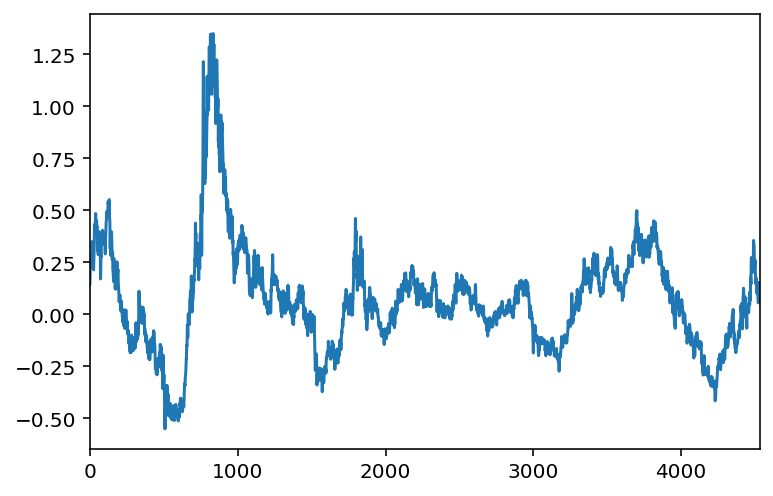

In [22]:
newdf['KRXsemiconductor_close'].plot()

In [23]:
date = newdf.date

In [24]:
newdf.drop('date', axis = True, inplace = True)

In [25]:
# extract target
y_target = newdf['KRXsemiconductor_close']

In [27]:
# 260일
newdf = newdf[['KRXsemiconductor_close', 'OEKRKLARIndex1', 'SKLIWNRSIndex260', 'MediaTek_close', 'TokyoElectron_close', 'SKLIEMPPIndex260', 'KOBONTLIndex260', 'SKLISVCIIndex60', 'KOUETTYIndex', 'KOQEEYOYIndex', 'FRNTTOTLIndex', 'KOFETOTIndex1', 'CONSSENTIndex60', 'GDPCPCECIndex', 'SKLIIMPTIndex1', 'LEIAVGWIndex120', 'KOBPCBIndex20', 'pbr', 'KOWDRIndex1', 'PCEDEFYIndex', 'CPMINEXOIndex20', 'NAPMNMIIndex20', 'NAPMNMIIndex1', 'EMPRGBCIIndex120', 'KOSPI200_change', 'SKLICONTIndex20', 'CPMINDXIndex20', 'CHALYOYIndex', 'KOEXTOTIndex260', 'KOWDRIndex60', 'SKLISVCIIndex120', 'SKLILCIndex1', 'KOBPCBIndex5', 'CICRTOTIndex1', 'USEMNCHGIndex', 'Nuvoton_change', 'KOBPCBIndex1', 'USTBEXPIndex260', 'EMPRGBCIIndex20', 'CHPMINDXIndex20', 'JOLTSEPSIndex', 'CNCILIIndex20', 'CNCILIIndex1', 'CNCILIIndex5', 'OUTFGAFIndex1', 'AWHTOTLIndex1', 'KOIPMYIndex', 'Intel_change', 'Amazon_product', 'PIDSPINXIndex60', 'AppliedMaterials_product', 'APPLE_change', 'ISECloudComputingIndex_change', 'ShinEtsuChemical_volume', 'QCOM_change', 'INJCJCIndex5', 'KOCGCGYIndex', 'Amazon_change', 'SKLINEIndex1', 'LEIACEIndex120', 'SKhynix_change', 'UMC_change', 'HPE_product', 'Google_change', 'TokyoElectron_product', 'CFNAIIndex5', 'CFNAIIndex20']
]

In [28]:
a, b = dmatrices('KRXsemiconductor_close ~ OEKRKLARIndex1+ SKLIWNRSIndex260+ MediaTek_close+ TokyoElectron_close+ SKLIEMPPIndex260+ KOBONTLIndex260+ SKLISVCIIndex60+ KOUETTYIndex+ KOQEEYOYIndex+ FRNTTOTLIndex+ KOFETOTIndex1+ CONSSENTIndex60+ GDPCPCECIndex+ SKLIIMPTIndex1+ LEIAVGWIndex120+ KOBPCBIndex20+ pbr+ KOWDRIndex1+ PCEDEFYIndex+ CPMINEXOIndex20+ NAPMNMIIndex20+ NAPMNMIIndex1+ EMPRGBCIIndex120+ KOSPI200_change+ SKLICONTIndex20+ CPMINDXIndex20+ CHALYOYIndex+ KOEXTOTIndex260+ KOWDRIndex60+ SKLISVCIIndex120+ SKLILCIndex1+ KOBPCBIndex5+ CICRTOTIndex1+ USEMNCHGIndex+ Nuvoton_change+ KOBPCBIndex1+ USTBEXPIndex260+ EMPRGBCIIndex20+ CHPMINDXIndex20+ JOLTSEPSIndex+ CNCILIIndex20+ CNCILIIndex1+ CNCILIIndex5+ OUTFGAFIndex1+ AWHTOTLIndex1+ KOIPMYIndex+ Intel_change+ Amazon_product+ PIDSPINXIndex60+ AppliedMaterials_product+ APPLE_change+ ISECloudComputingIndex_change+ ShinEtsuChemical_volume+ QCOM_change+ INJCJCIndex5+ KOCGCGYIndex+ Amazon_change+ SKLINEIndex1+ LEIACEIndex120+ SKhynix_change+ UMC_change+ HPE_product+ Google_change+ TokyoElectron_product+ CFNAIIndex5+ CFNAIIndex20', newdf, return_type = 'dataframe')


In [29]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns 
vif

,VIF Factor,features
0,913.774435,Intercept
1,4.743386,OEKRKLARIndex1
2,3.271153,SKLIWNRSIndex260
3,2.775175,MediaTek_close
4,7.008971,TokyoElectron_close
...,...,...
62,1.010435,HPE_product
63,1.968935,Google_change
64,1.010224,TokyoElectron_product
65,4.420553,CFNAIIndex5


In [30]:
vif.drop(0, inplace = True)

In [31]:
vif.sort_values(by = 'VIF Factor', inplace = True)

In [32]:
vif_columns = vif[vif['VIF Factor']  <=  10].features

In [33]:
len(newdf.columns)

67

In [40]:
newdf.drop(['KRXsemiconductor_close'], axis = 1, inplace = True)

In [41]:
newdf = newdf[list(vif_columns)]

In [26]:
newdf.columns

Index(['SPXIndex', 'MSRUITIndex', 'MSRUMATIndex', 'MXWO0ITIndex', 'MXWO0MTIndex', 'MXUS0ITIndex',
       'MXEF0ITIndex', 'MXEF0MTIndex', 'CL1Comdty', 'LMAHDS03Comdty',
       ...
       'Philadelphia_product', 'QCOM_product', 'SamsungElectronics_product',
       'ShinEtsuChemical_product', 'Siltronic_product', 'SKhynix_product', 'Sumco_product',
       'TokyoElectron_product', 'TSMC_product', 'UMC_product'],
      dtype='object', length=592)

In [27]:
len(newdf.columns)

592

In [28]:
newdf.drop(['SamsungElectronics_product', 'KRXsemiconductor_close'], axis = 1, inplace = True)

In [29]:
# scaling 하기전에 columns 뽑기 
col_name = newdf.columns

In [30]:
# scaling과 동시에 변환
#newdf = PowerTransformer().fit_transform(newdf)
newdf = StandardScaler().fit_transform(newdf)
#newdf = newdf.apply(lambda x : np.log1p(x))
#newdf = MinMaxScaler().fit_transfrom(newdf)

In [31]:
# scaling하면 colname사라지므로 다시 생성
newdf = pd.DataFrame(newdf, columns = col_name)

In [32]:
len(newdf.columns)

590

In [33]:
newdf.isna().sum().sum()

0

In [34]:
# extract X_data
X_data = newdf.copy()

### 이 단계에서 PCA를 적용해봐

In [35]:
#pca = PCA(n_components = 20)

In [36]:
#pca.fit(X_data)

In [35]:
#X_pca = pca.transform(X_data)

In [36]:
# shape check
#X_pca.shape

(5051, 20)

In [37]:
# random split과 not random split
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [ ]:
## Feature Selection Code
# Forward stepwise feature selection
# linear model 기준으로 유효 feature 뽑기. 돌리지 않아도 되는 코드

np.random.seed(0)

feature_name = list(X_train.columns)
feature_selected = []
score = []

for i in range(X_train.shape[1]):
    score_temp_list = np.zeros(len(feature_name))
    for j in range(len(feature_name)):
        temp = feature_selected.copy() 
        temp.append(feature_name[j])
        x_temp = X_train[temp]
        lr_temp = LinearRegression() 
        lr_temp.fit(x_temp, y_train)
        predict_temp = lr_temp.predict(X_test[temp])
        r2_temp = r2_score(y_test, predict_temp)
        score_temp = r2_temp
        score_temp_list[j] = score_temp 
        
    temp = feature_name[score_temp_list.argmax()]
    feature_selected.append(temp)
    feature_name.remove(temp)
    score.append(score_temp_list.max())
    print("%02d Selected: "%i, feature_selected)
    print("%02d Score : "%i, np.round(10000*np.array(score))/10000)
        
# finally selected features
feature_selected_final = feature_selected[:(np.array(score).argmax() + 1)]

00 Selected:  ['MSRUMATIndex']
00 Score :  [0.6296]
01 Selected:  ['MSRUMATIndex', 'SKLICONEIndex']
01 Score :  [0.6296 0.7373]
02 Selected:  ['MSRUMATIndex', 'SKLICONEIndex', 'KOIPMYIndex']
02 Score :  [0.6296 0.7373 0.7975]
03 Selected:  ['MSRUMATIndex', 'SKLICONEIndex', 'KOIPMYIndex', 'KOPPIIndex']
03 Score :  [0.6296 0.7373 0.7975 0.8246]
04 Selected:  ['MSRUMATIndex', 'SKLICONEIndex', 'KOIPMYIndex', 'KOPPIIndex', 'KOEXPTIMIndex']
04 Score :  [0.6296 0.7373 0.7975 0.8246 0.8497]
05 Selected:  ['MSRUMATIndex', 'SKLICONEIndex', 'KOIPMYIndex', 'KOPPIIndex', 'KOEXPTIMIndex', 'KOEAEPRIndex']
05 Score :  [0.6296 0.7373 0.7975 0.8246 0.8497 0.8624]
06 Selected:  ['MSRUMATIndex', 'SKLICONEIndex', 'KOIPMYIndex', 'KOPPIIndex', 'KOEXPTIMIndex', 'KOEAEPRIndex', 'JNVNIYOYIndex']
06 Score :  [0.6296 0.7373 0.7975 0.8246 0.8497 0.8624 0.8767]
07 Selected:  ['MSRUMATIndex', 'SKLICONEIndex', 'KOIPMYIndex', 'KOPPIIndex', 'KOEXPTIMIndex', 'KOEAEPRIndex', 'JNVNIYOYIndex', 'KOIPOPSMIndex']
07 Score :  

In [37]:
# 이건 PCA를 위한 Data split
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y_target, test_size = 0.2, shuffle = False)

# Linear Feature Selection
## 안돌려도 무방

# Metric Class

In [51]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

# Linear Model

In [52]:
# linear model select
lr_reg = LinearRegression()
#lasso = Lasso(alpha = 100)

In [53]:
lr_reg.fit(X_train, y_train)
y_pred = lr_reg.predict(X_test)

In [54]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.851677,0.6456,0.0636,0.1072,0.818002,0.808


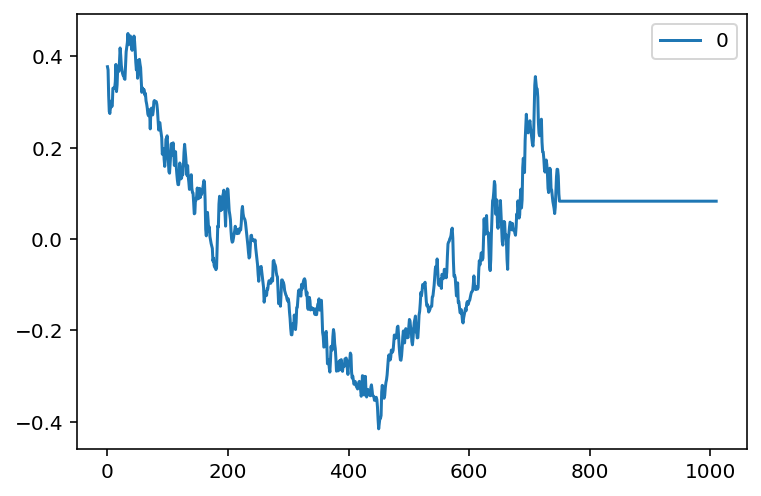

In [81]:
pd.DataFrame(y_test).plot()

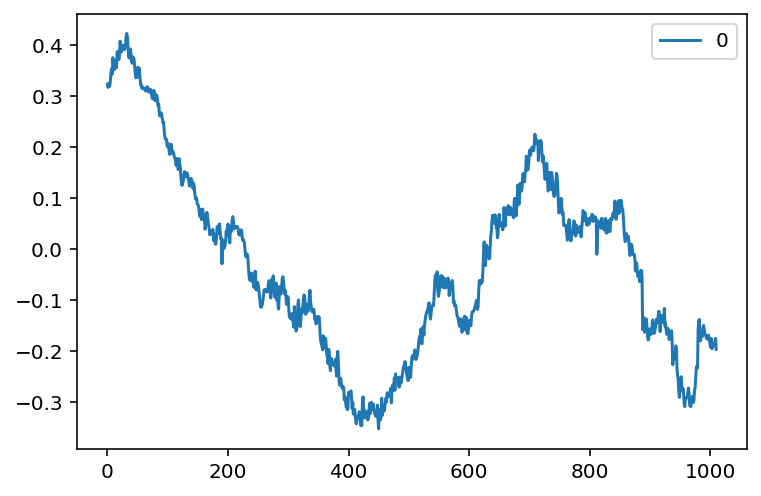

In [82]:
pd.DataFrame(y_pred).plot()

In [55]:
#ridge = Ridge(alpha = 10)
#ridge.fit(X_train, y_train)
#ridge_pred = ridge.predict(X_test)

# Tree Model

In [72]:
#dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 100)
#rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
#gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
#xgb_reg = XGBRegressor(n_estimators = 1000)
#lgb_reg = LGBMRegressor(n_estimators = 3000)

In [73]:
#lgb_reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
#lgb_pred = lgb_reg.predict(X_test)

### Metric function 실행 

In [75]:
#metr = CustomMetric(lgb_pred, y_test)
#metr.makedf()
#metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.391498,0.1376,1.3808,1.8314,0.598417,0.664694


In [176]:
#metr = CustomMetric(ridge_pred, y_test)
#metr.makedf()
#metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.513346,0.2582,1.2972,1.6985,0.631058,0.710059


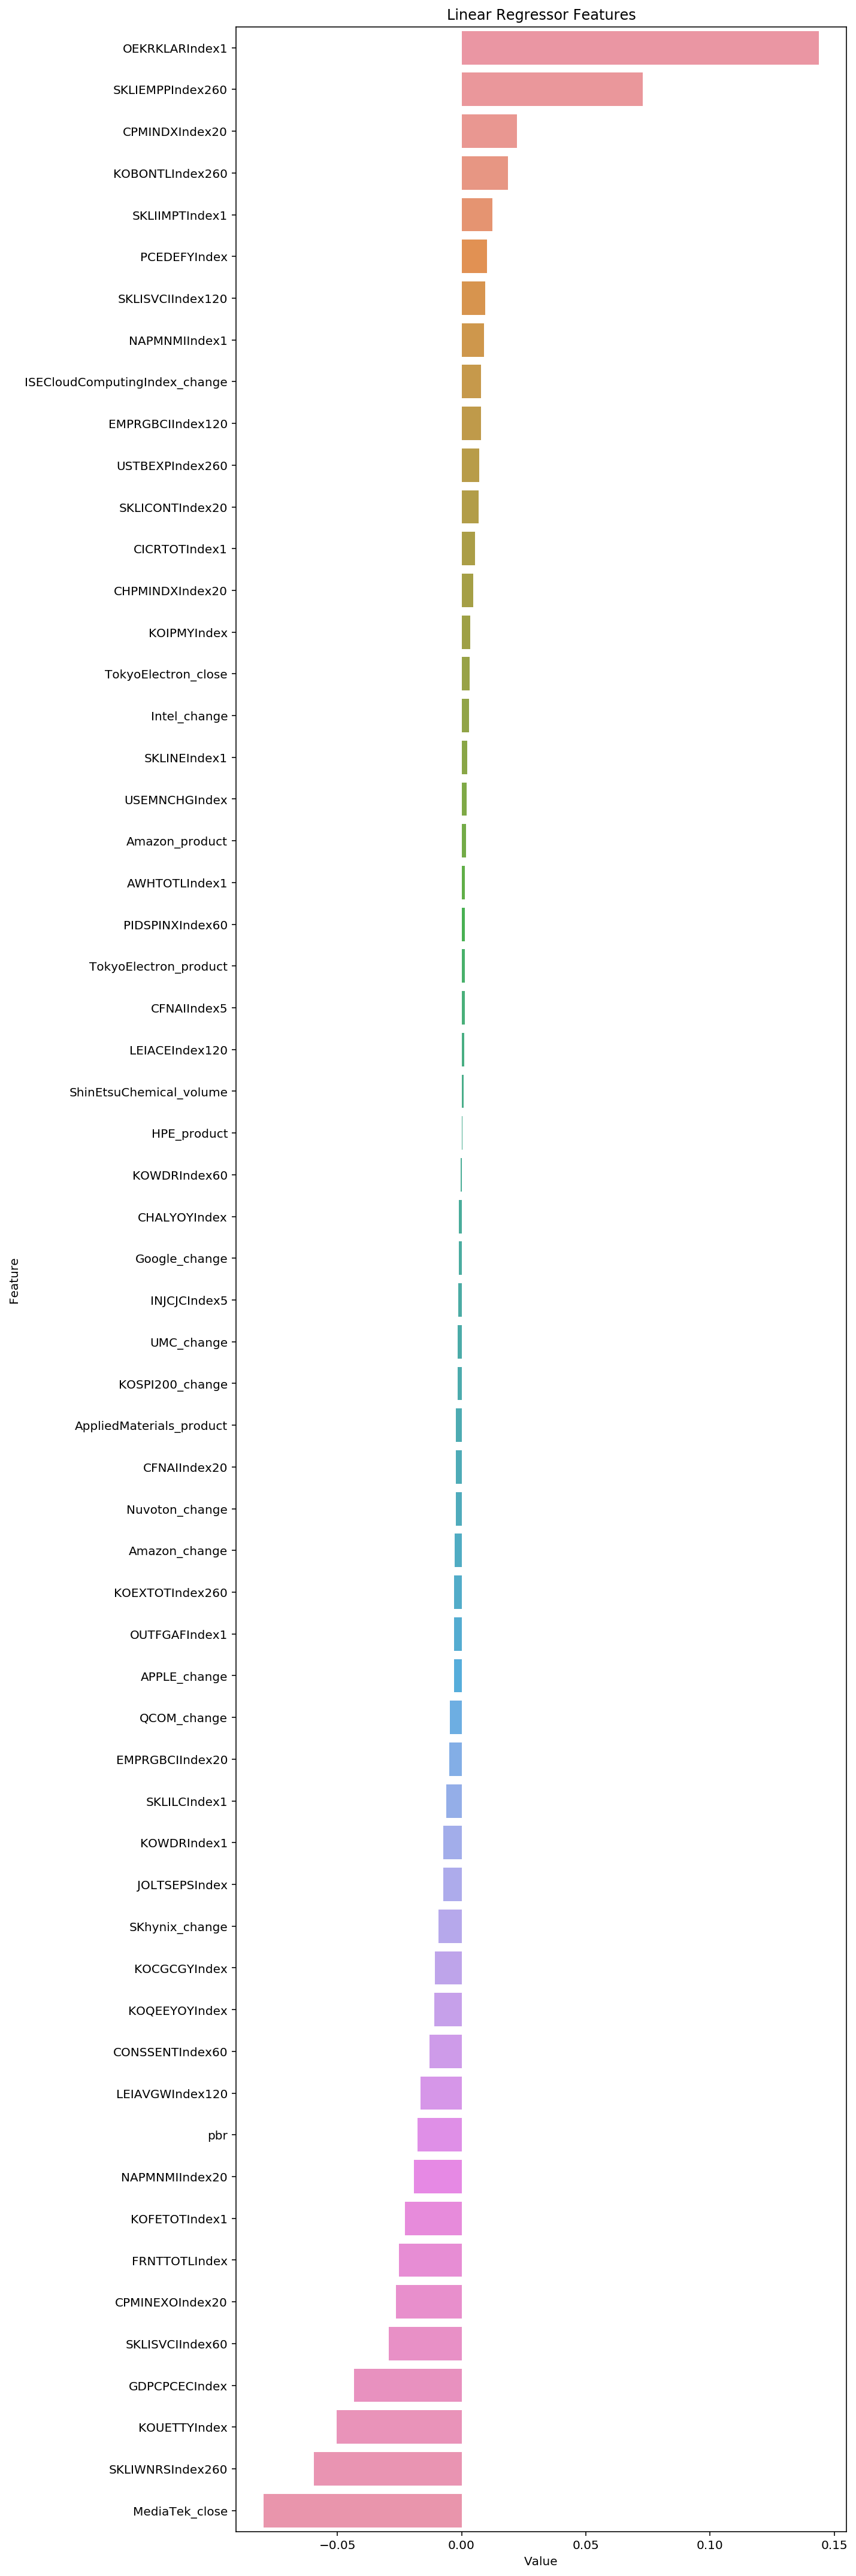

In [74]:
coef_imp = pd.DataFrame(sorted(zip(lr_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

# Feature Importance Visualization

Linear Model은 회귀계수로 나오므로 아래와 같이 시각화

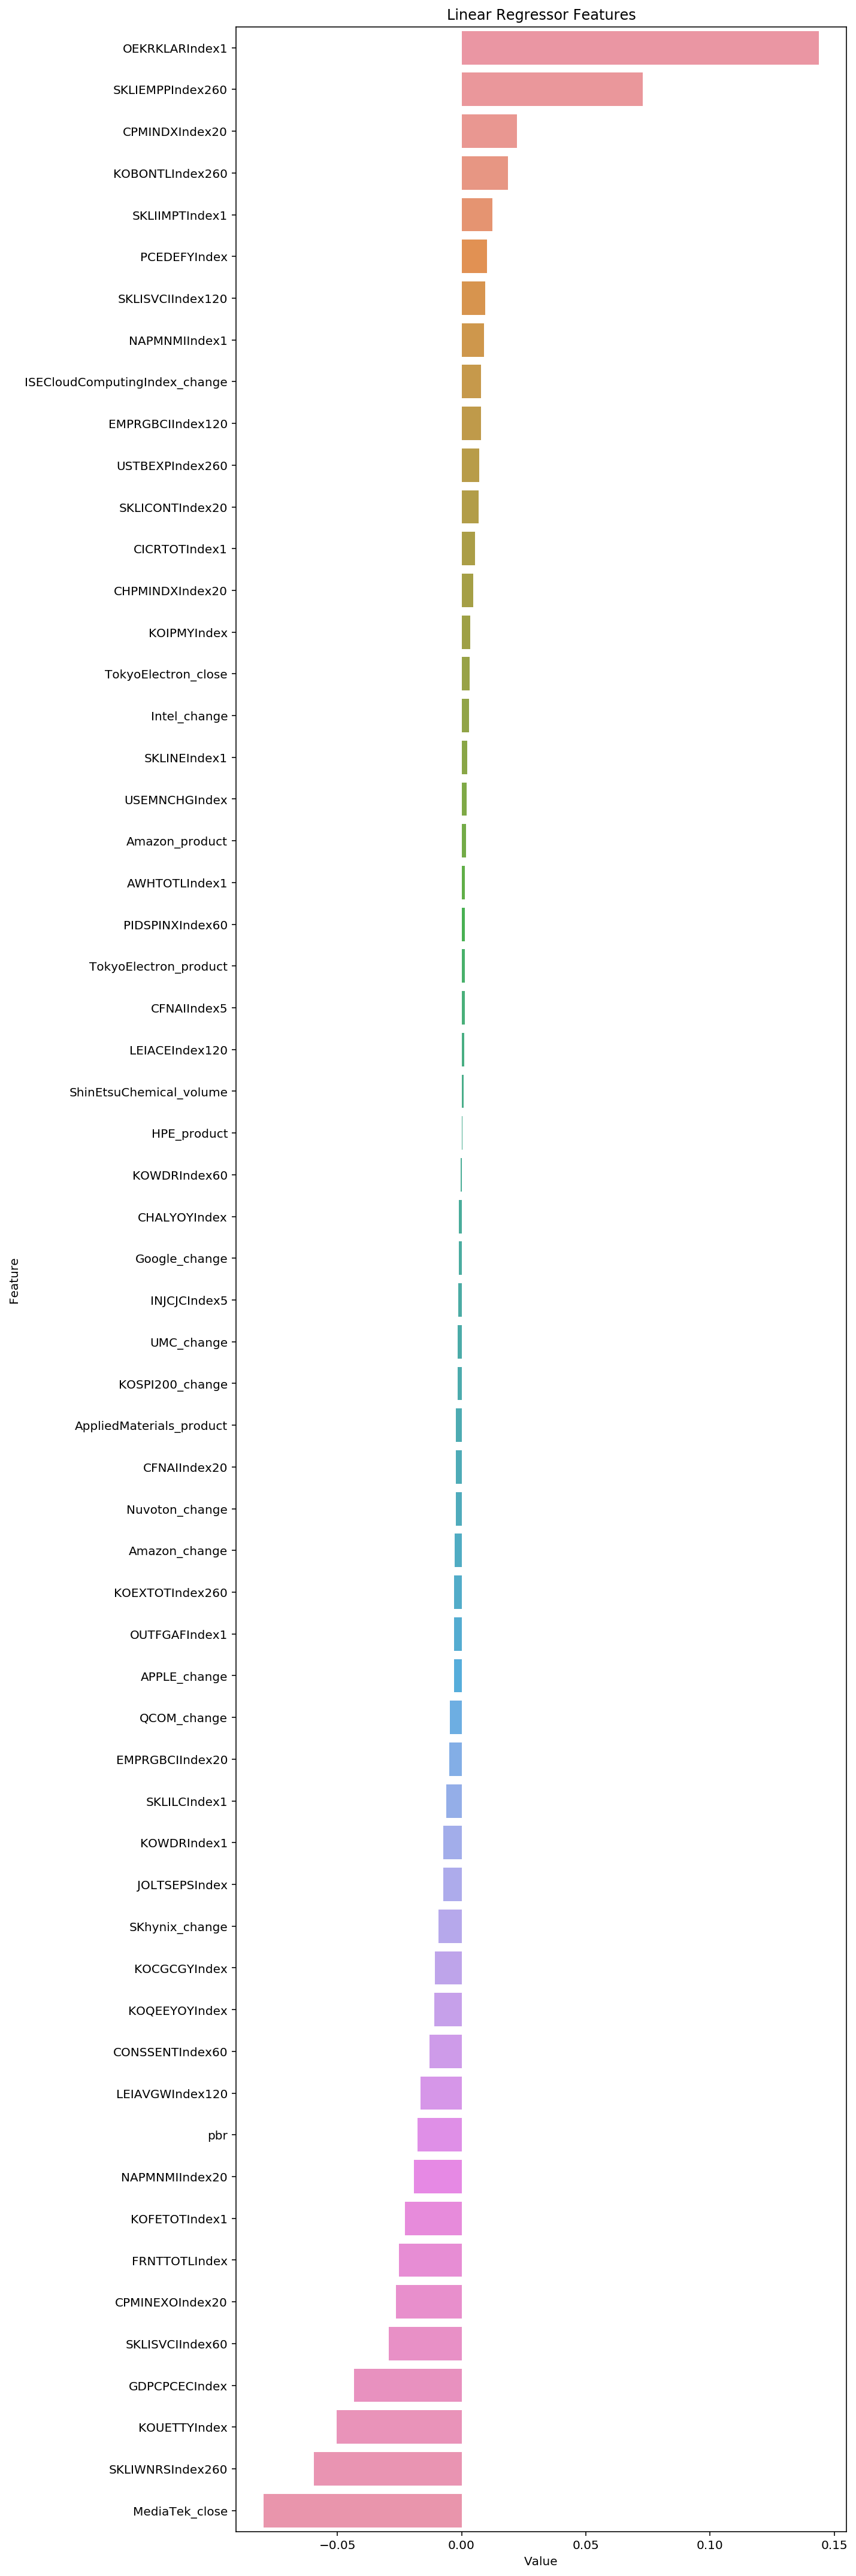

In [75]:
coef_imp = pd.DataFrame(sorted(zip(lr_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

Tree Model은 feature importance가 따로 뽑히므로 아래와 같이 시각화

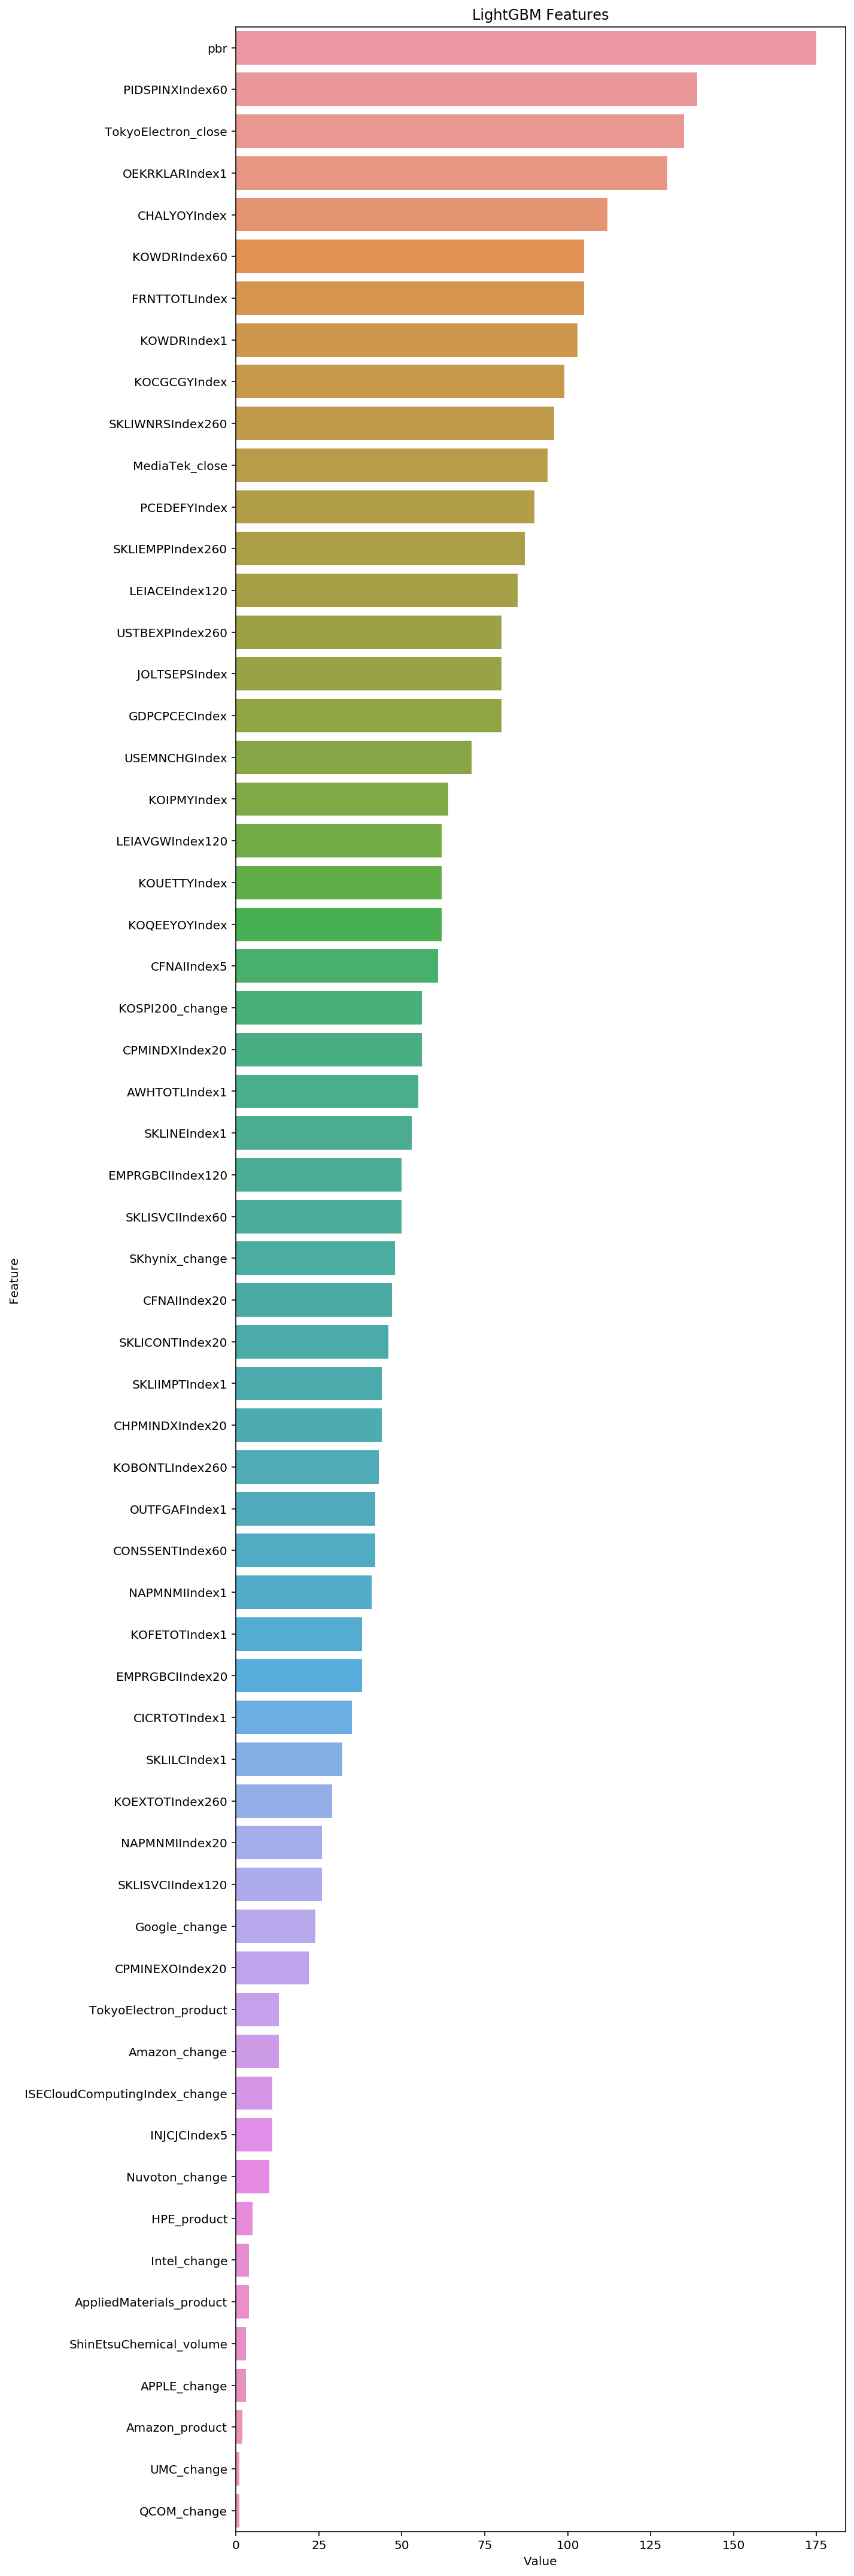

In [76]:
feat_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
feat_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = feat_imp.sort_values(by = 'Value', ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances_1.png')
plt.show()

# Optuna AutoML을 통한 LightGBM Hyperparameter tuning

In [56]:
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import r2_score
import optuna
import optuna.integration.lightgbm as lgb

In [57]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
    'boosting_type': 'gbdt',
}

best_params, tuning_history = dict(), list()

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dval],
                  best_params=best_params,
                  tuning_history=tuning_history,
                  verbose_eval=100,
                  early_stopping_rounds=100,
                  )

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
r2_score = r2_score(y_test, prediction)

print('Number of finished trials: {}'.format(len(tuning_history)))
print('Best params:', best_params)
print('  r2_score = {}'.format(r2_score))
print('  Params: ')
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000237458	valid_1's l2: 0.0305782
Early stopping, best iteration is:
[22]	training's l2: 0.00217013	valid_1's l2: 0.0297491


tune_feature_fraction, val_score: 0.029749:  14%|#4        | 1/7 [00:00<00:01,  4.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000227858	valid_1's l2: 0.0272594
[200]	training's l2: 7.75512e-05	valid_1's l2: 0.0272629
[300]	training's l2: 3.30023e-05	valid_1's l2: 0.0272011
Early stopping, best iteration is:
[283]	training's l2: 3.79898e-05	valid_1's l2: 0.027179


tune_feature_fraction, val_score: 0.027179:  29%|##8       | 2/7 [00:00<00:01,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000217713	valid_1's l2: 0.0237091
Early stopping, best iteration is:
[22]	training's l2: 0.00204924	valid_1's l2: 0.0233633


tune_feature_fraction, val_score: 0.023363:  43%|####2     | 3/7 [00:01<00:01,  3.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000209857	valid_1's l2: 0.0269098
Early stopping, best iteration is:
[77]	training's l2: 0.000293064	valid_1's l2: 0.0267447


tune_feature_fraction, val_score: 0.023363:  57%|#####7    | 4/7 [00:01<00:01,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000207371	valid_1's l2: 0.0227185
[200]	training's l2: 7.06001e-05	valid_1's l2: 0.0227328
Early stopping, best iteration is:
[105]	training's l2: 0.000194396	valid_1's l2: 0.022674


tune_feature_fraction, val_score: 0.022674:  71%|#######1  | 5/7 [00:01<00:00,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000211606	valid_1's l2: 0.0216229
[200]	training's l2: 6.98395e-05	valid_1's l2: 0.0216645
Early stopping, best iteration is:
[102]	training's l2: 0.0002056	valid_1's l2: 0.0216072


tune_feature_fraction, val_score: 0.021607:  86%|########5 | 6/7 [00:02<00:00,  2.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000214063	valid_1's l2: 0.0231041
Early stopping, best iteration is:
[87]	training's l2: 0.000257207	valid_1's l2: 0.0230393


tune_num_leaves, val_score: 0.021607:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000417863	valid_1's l2: 0.023907
Early stopping, best iteration is:
[63]	training's l2: 0.000687265	valid_1's l2: 0.0235456


tune_num_leaves, val_score: 0.021607:   5%|5         | 1/20 [00:00<00:05,  3.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.46935e-05	valid_1's l2: 0.022789
Early stopping, best iteration is:
[63]	training's l2: 6.24817e-05	valid_1's l2: 0.0227144


tune_num_leaves, val_score: 0.021607:  10%|#         | 2/20 [00:01<00:10,  1.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.23564e-05	valid_1's l2: 0.0217867
[200]	training's l2: 5.53432e-06	valid_1's l2: 0.0217751
Early stopping, best iteration is:
[168]	training's l2: 8.85344e-06	valid_1's l2: 0.0217666


tune_num_leaves, val_score: 0.021607:  15%|#5        | 3/20 [00:03<00:14,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00015851	valid_1's l2: 0.0224169
[200]	training's l2: 4.40973e-05	valid_1's l2: 0.0223739
Early stopping, best iteration is:
[158]	training's l2: 7.19673e-05	valid_1's l2: 0.0223325


tune_num_leaves, val_score: 0.021607:  20%|##        | 4/20 [00:03<00:12,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.40036e-05	valid_1's l2: 0.0223547
Early stopping, best iteration is:
[46]	training's l2: 0.000247031	valid_1's l2: 0.022316


tune_num_leaves, val_score: 0.021607:  25%|##5       | 5/20 [00:04<00:11,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.5701e-05	valid_1's l2: 0.0222722
Early stopping, best iteration is:
[55]	training's l2: 8.86972e-05	valid_1's l2: 0.0222051


tune_num_leaves, val_score: 0.021607:  30%|###       | 6/20 [00:05<00:11,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.80287e-05	valid_1's l2: 0.0221015
[200]	training's l2: 5.59216e-06	valid_1's l2: 0.0220773
[300]	training's l2: 1.80431e-06	valid_1's l2: 0.0220736
Early stopping, best iteration is:
[240]	training's l2: 3.4135e-06	valid_1's l2: 0.0220717


tune_num_leaves, val_score: 0.021607:  35%|###5      | 7/20 [00:07<00:15,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.46935e-05	valid_1's l2: 0.022789
Early stopping, best iteration is:
[63]	training's l2: 6.24817e-05	valid_1's l2: 0.0227144


tune_num_leaves, val_score: 0.021607:  40%|####      | 8/20 [00:08<00:14,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.46935e-05	valid_1's l2: 0.022789
Early stopping, best iteration is:
[63]	training's l2: 6.24817e-05	valid_1's l2: 0.0227144


tune_num_leaves, val_score: 0.021607:  45%|####5     | 9/20 [00:09<00:13,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.46935e-05	valid_1's l2: 0.022789
Early stopping, best iteration is:
[63]	training's l2: 6.24817e-05	valid_1's l2: 0.0227144


tune_num_leaves, val_score: 0.021607:  50%|#####     | 10/20 [00:11<00:11,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.46935e-05	valid_1's l2: 0.022789
Early stopping, best iteration is:
[63]	training's l2: 6.24817e-05	valid_1's l2: 0.0227144


tune_num_leaves, val_score: 0.021607:  55%|#####5    | 11/20 [00:12<00:10,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.35527e-05	valid_1's l2: 0.0215974
[200]	training's l2: 5.68149e-06	valid_1's l2: 0.021531
[300]	training's l2: 1.69913e-06	valid_1's l2: 0.0215257
[400]	training's l2: 6.26541e-07	valid_1's l2: 0.0215227
[500]	training's l2: 2.6178e-07	valid_1's l2: 0.0215211
[600]	training's l2: 1.17551e-07	valid_1's l2: 0.0215198
[700]	training's l2: 5.31222e-08	valid_1's l2: 0.0215183
[800]	training's l2: 2.69225e-08	valid_1's l2: 0.0215177
[900]	training's l2: 1.37327e-08	valid_1's l2: 0.0215171
[1000]	training's l2: 7.10375e-09	valid_1's l2: 0.0215167
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 7.10375e-09	valid_1's l2: 0.0215167


tune_num_leaves, val_score: 0.021517:  60%|######    | 12/20 [00:18<00:20,  2.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.51901e-05	valid_1's l2: 0.0207947
[200]	training's l2: 6.78857e-06	valid_1's l2: 0.0207933
[300]	training's l2: 2.2271e-06	valid_1's l2: 0.0207809
Early stopping, best iteration is:
[284]	training's l2: 2.58893e-06	valid_1's l2: 0.0207805


tune_num_leaves, val_score: 0.020781:  65%|######5   | 13/20 [00:20<00:17,  2.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.27408e-05	valid_1's l2: 0.0206154
Early stopping, best iteration is:
[50]	training's l2: 0.000193448	valid_1's l2: 0.0205179


tune_num_leaves, val_score: 0.020518:  70%|#######   | 14/20 [00:20<00:11,  1.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.64382e-05	valid_1's l2: 0.0226416
[200]	training's l2: 6.16131e-06	valid_1's l2: 0.0226121
[300]	training's l2: 2.07602e-06	valid_1's l2: 0.0226032
[400]	training's l2: 7.98122e-07	valid_1's l2: 0.0225975
Early stopping, best iteration is:
[399]	training's l2: 8.07158e-07	valid_1's l2: 0.0225964


tune_num_leaves, val_score: 0.020518:  75%|#######5  | 15/20 [00:24<00:12,  2.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.14676e-05	valid_1's l2: 0.0215995
Early stopping, best iteration is:
[83]	training's l2: 7.44647e-05	valid_1's l2: 0.021568


tune_num_leaves, val_score: 0.020518:  80%|########  | 16/20 [00:25<00:07,  2.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00128488	valid_1's l2: 0.0266133
Early stopping, best iteration is:
[39]	training's l2: 0.00355715	valid_1's l2: 0.0258347


tune_num_leaves, val_score: 0.020518:  85%|########5 | 17/20 [00:25<00:04,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 9.93249e-05	valid_1's l2: 0.0211564
Early stopping, best iteration is:
[47]	training's l2: 0.000322931	valid_1's l2: 0.0209187


tune_num_leaves, val_score: 0.020518:  90%|######### | 18/20 [00:26<00:02,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 2.66591e-05	valid_1's l2: 0.0222219
Early stopping, best iteration is:
[86]	training's l2: 3.55734e-05	valid_1's l2: 0.0221974


tune_num_leaves, val_score: 0.020518:  95%|#########5| 19/20 [00:27<00:01,  1.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 4.51549e-05	valid_1's l2: 0.0213766
Early stopping, best iteration is:
[50]	training's l2: 0.000171657	valid_1's l2: 0.0213267


tune_num_leaves, val_score: 0.020518: 100%|##########| 20/20 [00:28<00:00,  1.43s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.37021e-05	valid_1's l2: 0.0236558
[200]	training's l2: 1.25262e-05	valid_1's l2: 0.0236368
Early stopping, best iteration is:
[138]	training's l2: 3.20742e-05	valid_1's l2: 0.0235871


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  10%|#         | 1/10 [00:01<00:10,  1.12s/it][I 2020-03-18 17:00:07,503] Finished trial#0 resulted in value: 0.023587085703411382. Current best value is 0.023587085703411382 with parameters: {'bagging_fraction': 0.8705214025060796, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  10%|#         | 1/10 [00:01<00:10,  1.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000171116	valid_1's l2: 0.0261457
Early stopping, best iteration is:
[42]	training's l2: 0.000477103	valid_1's l2: 0.0260218


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  20%|##        | 2/10 [00:01<00:07,  1.04it/s][I 2020-03-18 17:00:08,093] Finished trial#1 resulted in value: 0.026021805920843372. Current best value is 0.023587085703411382 with parameters: {'bagging_fraction': 0.8705214025060796, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  20%|##        | 2/10 [00:01<00:07,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000134119	valid_1's l2: 0.025229
Early stopping, best iteration is:
[64]	training's l2: 0.000243138	valid_1's l2: 0.0251025


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  30%|###       | 3/10 [00:02<00:06,  1.12it/s][I 2020-03-18 17:00:08,831] Finished trial#2 resulted in value: 0.025102524150604343. Current best value is 0.023587085703411382 with parameters: {'bagging_fraction': 0.8705214025060796, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  30%|###       | 3/10 [00:02<00:06,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000238864	valid_1's l2: 0.0266956
Early stopping, best iteration is:
[51]	training's l2: 0.000481253	valid_1's l2: 0.0265564


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  40%|####      | 4/10 [00:03<00:04,  1.26it/s][I 2020-03-18 17:00:09,394] Finished trial#3 resulted in value: 0.02655644697404489. Current best value is 0.023587085703411382 with parameters: {'bagging_fraction': 0.8705214025060796, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  40%|####      | 4/10 [00:03<00:04,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000277592	valid_1's l2: 0.0264337
[200]	training's l2: 0.0001213	valid_1's l2: 0.0264246
[300]	training's l2: 7.2964e-05	valid_1's l2: 0.0263105
[400]	training's l2: 4.18471e-05	valid_1's l2: 0.0263115
Early stopping, best iteration is:
[308]	training's l2: 6.98182e-05	valid_1's l2: 0.0263024


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  50%|#####     | 5/10 [00:04<00:05,  1.02s/it][I 2020-03-18 17:00:10,943] Finished trial#4 resulted in value: 0.026302367711840947. Current best value is 0.023587085703411382 with parameters: {'bagging_fraction': 0.8705214025060796, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  50%|#####     | 5/10 [00:04<00:05,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000170477	valid_1's l2: 0.0234844
Early stopping, best iteration is:
[70]	training's l2: 0.000270177	valid_1's l2: 0.0233703


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  60%|######    | 6/10 [00:05<00:03,  1.09it/s][I 2020-03-18 17:00:11,629] Finished trial#5 resulted in value: 0.023370315030599657. Current best value is 0.023370315030599657 with parameters: {'bagging_fraction': 0.48799271096834007, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  60%|######    | 6/10 [00:05<00:03,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000117628	valid_1's l2: 0.0208131
Early stopping, best iteration is:
[90]	training's l2: 0.000137425	valid_1's l2: 0.0207696


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  70%|#######   | 7/10 [00:06<00:02,  1.12it/s][I 2020-03-18 17:00:12,454] Finished trial#6 resulted in value: 0.020769636819099758. Current best value is 0.020769636819099758 with parameters: {'bagging_fraction': 0.6000946908288317, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  70%|#######   | 7/10 [00:06<00:02,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000116881	valid_1's l2: 0.022867
[200]	training's l2: 3.67382e-05	valid_1's l2: 0.0226303
Early stopping, best iteration is:
[181]	training's l2: 4.38516e-05	valid_1's l2: 0.0226025


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  80%|########  | 8/10 [00:07<00:01,  1.01it/s][I 2020-03-18 17:00:13,690] Finished trial#7 resulted in value: 0.02260247248443298. Current best value is 0.020769636819099758 with parameters: {'bagging_fraction': 0.6000946908288317, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  80%|########  | 8/10 [00:07<00:01,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.77421e-05	valid_1's l2: 0.0220095
Early stopping, best iteration is:
[55]	training's l2: 0.000173151	valid_1's l2: 0.0219313


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  90%|######### | 9/10 [00:08<00:00,  1.09it/s][I 2020-03-18 17:00:14,434] Finished trial#8 resulted in value: 0.021931290963150704. Current best value is 0.020769636819099758 with parameters: {'bagging_fraction': 0.6000946908288317, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518:  90%|######### | 9/10 [00:08<00:00,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.72331e-05	valid_1's l2: 0.022064
Early stopping, best iteration is:
[58]	training's l2: 0.000156581	valid_1's l2: 0.0220171


tune_bagging_fraction_and_bagging_freq, val_score: 0.020518: 100%|##########| 10/10 [00:08<00:00,  1.13it/s][I 2020-03-18 17:00:15,232] Finished trial#9 resulted in value: 0.022017072228541674. Current best value is 0.020769636819099758 with parameters: {'bagging_fraction': 0.6000946908288317, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.020518: 100%|##########| 10/10 [00:08<00:00,  1.13it/s]
tune_feature_fraction, val_score: 0.020518:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.16338e-05	valid_1's l2: 0.023422
Early stopping, best iteration is:
[36]	training's l2: 0.000338827	valid_1's l2: 0.0233552


tune_feature_fraction, val_score: 0.020518:  17%|#6        | 1/6 [00:00<00:02,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.4573e-05	valid_1's l2: 0.0241365
[200]	training's l2: 9.10063e-06	valid_1's l2: 0.0240682
[300]	training's l2: 2.3652e-06	valid_1's l2: 0.0240725
Early stopping, best iteration is:
[208]	training's l2: 8.0525e-06	valid_1's l2: 0.0240664


tune_feature_fraction, val_score: 0.020518:  33%|###3      | 2/6 [00:02<00:03,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.27295e-05	valid_1's l2: 0.0234504
Early stopping, best iteration is:
[42]	training's l2: 0.000255874	valid_1's l2: 0.0233519


tune_feature_fraction, val_score: 0.020518:  50%|#####     | 3/6 [00:02<00:02,  1.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.27096e-05	valid_1's l2: 0.0216786
[200]	training's l2: 8.41537e-06	valid_1's l2: 0.0216564
Early stopping, best iteration is:
[140]	training's l2: 2.35391e-05	valid_1's l2: 0.0216378


tune_feature_fraction, val_score: 0.020518:  67%|######6   | 4/6 [00:03<00:01,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.1667e-05	valid_1's l2: 0.0228177
[200]	training's l2: 8.25816e-06	valid_1's l2: 0.0228025
Early stopping, best iteration is:
[163]	training's l2: 1.51816e-05	valid_1's l2: 0.0227915


tune_feature_fraction, val_score: 0.020518:  83%|########3 | 5/6 [00:05<00:00,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.15663e-05	valid_1's l2: 0.0243831
Early stopping, best iteration is:
[81]	training's l2: 7.90135e-05	valid_1's l2: 0.0243352


tune_feature_fraction, val_score: 0.020518: 100%|##########| 6/6 [00:05<00:00,  1.02it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.020518:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.32544e-05	valid_1's l2: 0.0207812
Early stopping, best iteration is:
[44]	training's l2: 0.000236856	valid_1's l2: 0.0206298


tune_lambda_l1_and_lambda_l2, val_score: 0.020518:   5%|5         | 1/20 [00:00<00:12,  1.46it/s][I 2020-03-18 17:00:21,852] Finished trial#0 resulted in value: 0.02062980802792751. Current best value is 0.02062980802792751 with parameters: {'lambda_l1': 4.9519617636755704e-08, 'lambda_l2': 0.000420604327800172}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020518:   5%|5         | 1/20 [00:00<00:12,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.32538e-05	valid_1's l2: 0.0207812
Early stopping, best iteration is:
[44]	training's l2: 0.000236854	valid_1's l2: 0.0206298


tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  10%|#         | 2/20 [00:01<00:13,  1.36it/s][I 2020-03-18 17:00:22,712] Finished trial#1 resulted in value: 0.020629845188591393. Current best value is 0.02062980802792751 with parameters: {'lambda_l1': 4.9519617636755704e-08, 'lambda_l2': 0.000420604327800172}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  10%|#         | 2/20 [00:01<00:13,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.16604e-05	valid_1's l2: 0.0214909
Early stopping, best iteration is:
[41]	training's l2: 0.000289732	valid_1's l2: 0.0213958


tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  15%|#5        | 3/20 [00:02<00:12,  1.36it/s][I 2020-03-18 17:00:23,433] Finished trial#2 resulted in value: 0.021395801104961542. Current best value is 0.02062980802792751 with parameters: {'lambda_l1': 4.9519617636755704e-08, 'lambda_l2': 0.000420604327800172}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  15%|#5        | 3/20 [00:02<00:12,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.17929e-05	valid_1's l2: 0.0205567
[200]	training's l2: 8.25011e-06	valid_1's l2: 0.0205836
Early stopping, best iteration is:
[101]	training's l2: 5.05892e-05	valid_1's l2: 0.0205553


tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  20%|##        | 4/20 [00:03<00:12,  1.25it/s][I 2020-03-18 17:00:24,382] Finished trial#3 resulted in value: 0.020555257004371382. Current best value is 0.020555257004371382 with parameters: {'lambda_l1': 0.0013565711905175594, 'lambda_l2': 2.7918283790819807e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  20%|##        | 4/20 [00:03<00:12,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.22464e-05	valid_1's l2: 0.0212
Early stopping, best iteration is:
[30]	training's l2: 0.000512195	valid_1's l2: 0.0210608


tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  25%|##5       | 5/20 [00:03<00:11,  1.29it/s][I 2020-03-18 17:00:25,108] Finished trial#4 resulted in value: 0.021060841348364265. Current best value is 0.020555257004371382 with parameters: {'lambda_l1': 0.0013565711905175594, 'lambda_l2': 2.7918283790819807e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020518:  25%|##5       | 5/20 [00:03<00:11,  1.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000198958	valid_1's l2: 0.0201073
[200]	training's l2: 0.000127856	valid_1's l2: 0.0201254
Early stopping, best iteration is:
[104]	training's l2: 0.000191395	valid_1's l2: 0.0200862


tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  30%|###       | 6/20 [00:04<00:09,  1.41it/s][I 2020-03-18 17:00:25,656] Finished trial#5 resulted in value: 0.02008621121716738. Current best value is 0.02008621121716738 with parameters: {'lambda_l1': 0.3875110940078507, 'lambda_l2': 2.9763864531052007}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  30%|###       | 6/20 [00:04<00:09,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.21671e-05	valid_1's l2: 0.0205563
[200]	training's l2: 8.22289e-06	valid_1's l2: 0.0205245
[300]	training's l2: 2.05241e-06	valid_1's l2: 0.0204968
[400]	training's l2: 7.45112e-07	valid_1's l2: 0.0204966
[500]	training's l2: 3.58616e-07	valid_1's l2: 0.0204985
Early stopping, best iteration is:
[403]	training's l2: 7.26098e-07	valid_1's l2: 0.0204961


tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  35%|###5      | 7/20 [00:06<00:15,  1.20s/it][I 2020-03-18 17:00:27,995] Finished trial#6 resulted in value: 0.020496094861100697. Current best value is 0.02008621121716738 with parameters: {'lambda_l1': 0.3875110940078507, 'lambda_l2': 2.9763864531052007}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  35%|###5      | 7/20 [00:06<00:15,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.37877e-05	valid_1's l2: 0.0204657
[200]	training's l2: 8.66648e-06	valid_1's l2: 0.020448
Early stopping, best iteration is:
[164]	training's l2: 1.53332e-05	valid_1's l2: 0.0204389


tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  40%|####      | 8/20 [00:08<00:14,  1.21s/it][I 2020-03-18 17:00:29,227] Finished trial#7 resulted in value: 0.020438852280663913. Current best value is 0.02008621121716738 with parameters: {'lambda_l1': 0.3875110940078507, 'lambda_l2': 2.9763864531052007}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  40%|####      | 8/20 [00:08<00:14,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.45823e-05	valid_1's l2: 0.022159
Early stopping, best iteration is:
[46]	training's l2: 0.00022325	valid_1's l2: 0.0221338


tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  45%|####5     | 9/20 [00:08<00:11,  1.05s/it][I 2020-03-18 17:00:29,926] Finished trial#8 resulted in value: 0.022133792996279447. Current best value is 0.02008621121716738 with parameters: {'lambda_l1': 0.3875110940078507, 'lambda_l2': 2.9763864531052007}.
tune_lambda_l1_and_lambda_l2, val_score: 0.020086:  45%|####5     | 9/20 [00:08<00:11,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000520637	valid_1's l2: 0.0189093
Early stopping, best iteration is:
[78]	training's l2: 0.000560221	valid_1's l2: 0.0189039


tune_lambda_l1_and_lambda_l2, val_score: 0.018904:  50%|#####     | 10/20 [00:09<00:08,  1.22it/s][I 2020-03-18 17:00:30,200] Finished trial#9 resulted in value: 0.018903881331936212. Current best value is 0.018903881331936212 with parameters: {'lambda_l1': 1.7198605114049397, 'lambda_l2': 0.02621873171886693}.
tune_lambda_l1_and_lambda_l2, val_score: 0.018904:  50%|#####     | 10/20 [00:09<00:08,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000644487	valid_1's l2: 0.017481
Early stopping, best iteration is:
[95]	training's l2: 0.00064507	valid_1's l2: 0.017479


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  55%|#####5    | 11/20 [00:09<00:05,  1.53it/s][I 2020-03-18 17:00:30,461] Finished trial#10 resulted in value: 0.01747901425759218. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  55%|#####5    | 11/20 [00:09<00:05,  1.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000747031	valid_1's l2: 0.0187633
Early stopping, best iteration is:
[77]	training's l2: 0.000769086	valid_1's l2: 0.01874


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  60%|######    | 12/20 [00:09<00:04,  1.90it/s][I 2020-03-18 17:00:30,694] Finished trial#11 resulted in value: 0.01873998830690239. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  60%|######    | 12/20 [00:09<00:04,  1.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00157807	valid_1's l2: 0.0194031
Early stopping, best iteration is:
[79]	training's l2: 0.00158343	valid_1's l2: 0.0194015


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  65%|######5   | 13/20 [00:09<00:02,  2.37it/s][I 2020-03-18 17:00:30,871] Finished trial#12 resulted in value: 0.019401525585994377. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  65%|######5   | 13/20 [00:09<00:02,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00162787	valid_1's l2: 0.0184621
Early stopping, best iteration is:
[78]	training's l2: 0.00163077	valid_1's l2: 0.018436


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  70%|#######   | 14/20 [00:09<00:02,  2.87it/s][I 2020-03-18 17:00:31,047] Finished trial#13 resulted in value: 0.018435995227357865. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  70%|#######   | 14/20 [00:09<00:02,  2.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 6.37788e-05	valid_1's l2: 0.0222111
Early stopping, best iteration is:
[81]	training's l2: 9.57299e-05	valid_1's l2: 0.022184


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  75%|#######5  | 15/20 [00:10<00:02,  1.99it/s][I 2020-03-18 17:00:31,907] Finished trial#14 resulted in value: 0.02218395132442632. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  75%|#######5  | 15/20 [00:10<00:02,  1.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00192733	valid_1's l2: 0.0224811
Early stopping, best iteration is:
[73]	training's l2: 0.00193543	valid_1's l2: 0.0224403


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  80%|########  | 16/20 [00:10<00:01,  2.50it/s][I 2020-03-18 17:00:32,069] Finished trial#15 resulted in value: 0.022440309048859967. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  80%|########  | 16/20 [00:10<00:01,  2.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.42719e-05	valid_1's l2: 0.020341
[200]	training's l2: 8.85551e-06	valid_1's l2: 0.0202978
[300]	training's l2: 2.25327e-06	valid_1's l2: 0.0202809
[400]	training's l2: 7.88118e-07	valid_1's l2: 0.0202781
[500]	training's l2: 3.63658e-07	valid_1's l2: 0.0202795
Early stopping, best iteration is:
[432]	training's l2: 6.10049e-07	valid_1's l2: 0.0202767


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  85%|########5 | 17/20 [00:13<00:02,  1.01it/s][I 2020-03-18 17:00:34,422] Finished trial#16 resulted in value: 0.02027665081782001. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  85%|########5 | 17/20 [00:13<00:02,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000176761	valid_1's l2: 0.023182
[200]	training's l2: 0.000116972	valid_1's l2: 0.0232017
Early stopping, best iteration is:
[121]	training's l2: 0.000146296	valid_1's l2: 0.0231376


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  90%|######### | 18/20 [00:13<00:01,  1.17it/s][I 2020-03-18 17:00:34,965] Finished trial#17 resulted in value: 0.023137611047482517. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  90%|######### | 18/20 [00:13<00:01,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000182887	valid_1's l2: 0.0229327
[200]	training's l2: 0.000134363	valid_1's l2: 0.0228292
Early stopping, best iteration is:
[147]	training's l2: 0.000134866	valid_1's l2: 0.0228283


tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  95%|#########5| 19/20 [00:14<00:00,  1.33it/s][I 2020-03-18 17:00:35,489] Finished trial#18 resulted in value: 0.022828310413887245. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479:  95%|#########5| 19/20 [00:14<00:00,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.34923e-05	valid_1's l2: 0.0204975
[200]	training's l2: 8.62339e-06	valid_1's l2: 0.0204422
[300]	training's l2: 2.26279e-06	valid_1's l2: 0.0204351
Early stopping, best iteration is:
[235]	training's l2: 5.1167e-06	valid_1's l2: 0.0204313


tune_lambda_l1_and_lambda_l2, val_score: 0.017479: 100%|##########| 20/20 [00:15<00:00,  1.01it/s][I 2020-03-18 17:00:37,036] Finished trial#19 resulted in value: 0.020431334994627896. Current best value is 0.01747901425759218 with parameters: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.017479: 100%|##########| 20/20 [00:15<00:00,  1.26it/s]
tune_min_child_samples, val_score: 0.017479:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000455123	valid_1's l2: 0.0240721
Early stopping, best iteration is:
[94]	training's l2: 0.000456969	valid_1's l2: 0.0240705


tune_min_child_samples, val_score: 0.017479:  20%|##        | 1/5 [00:00<00:01,  3.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00051704	valid_1's l2: 0.0197103
Early stopping, best iteration is:
[95]	training's l2: 0.000518302	valid_1's l2: 0.0197086


tune_min_child_samples, val_score: 0.017479:  40%|####      | 2/5 [00:00<00:00,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000677715	valid_1's l2: 0.0184435
Early stopping, best iteration is:
[87]	training's l2: 0.000690142	valid_1's l2: 0.0184182


tune_min_child_samples, val_score: 0.017479:  60%|######    | 3/5 [00:00<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000828723	valid_1's l2: 0.0181792
Early stopping, best iteration is:
[95]	training's l2: 0.00083894	valid_1's l2: 0.0181675


tune_min_child_samples, val_score: 0.017479:  80%|########  | 4/5 [00:01<00:00,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00104041	valid_1's l2: 0.0221583
Early stopping, best iteration is:
[63]	training's l2: 0.00135533	valid_1's l2: 0.0219088


tune_min_child_samples, val_score: 0.017479: 100%|##########| 5/5 [00:01<00:00,  3.92it/s]


Number of finished trials: 68
Best params: {'lambda_l1': 2.3634375160000354, 'lambda_l2': 4.0893257714231686, 'num_leaves': 72, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  r2_score = -0.003399811905793193
  Params: 
    lambda_l1: 2.3634375160000354
    lambda_l2: 4.0893257714231686
    num_leaves: 72
    feature_fraction: 0.8999999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


### Tuning된 값 입력하여 모델 선언

In [58]:
lgb_reg = LGBMRegressor(lambda_l1 = 2.3634375160000354, lambda_l2 = 4.0893257714231686, num_leaves = 72, feature_fraction = 0.8999999999999999, bagging_fraction = 1, bagging_freq = 0, min_child_samples = 20)

In [59]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=1, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.8999999999999999, importance_type='split',
              lambda_l1=2.3634375160000354, lambda_l2=4.0893257714231686,
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=72, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [60]:
lgb_pred = lgb_reg.predict(X_test)

In [61]:
lgb_pred

array([ 0.28388889,  0.28920172,  0.28114401, ...,  0.01380833,
        0.01907664, -0.00323082])

In [62]:
y_test = np.array(y_test)

In [65]:
metr = CustomMetric(lgb_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.764243,0.4614,0.1044,0.1322,0.830861,0.913333


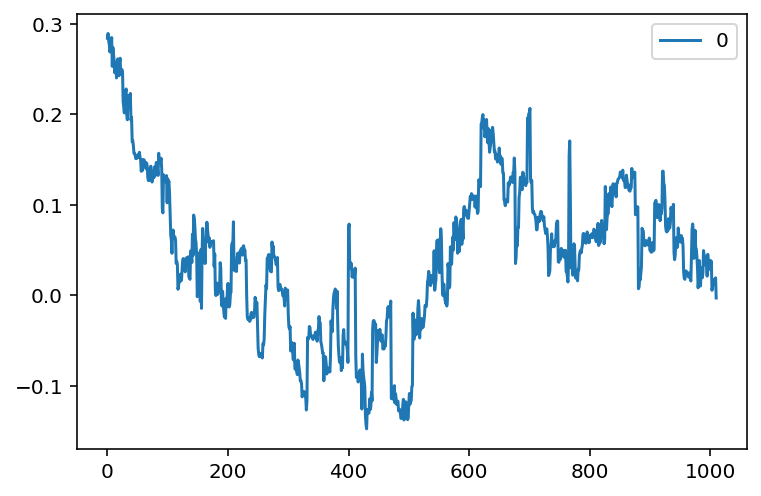

In [67]:
pd.DataFrame(lgb_pred).plot()

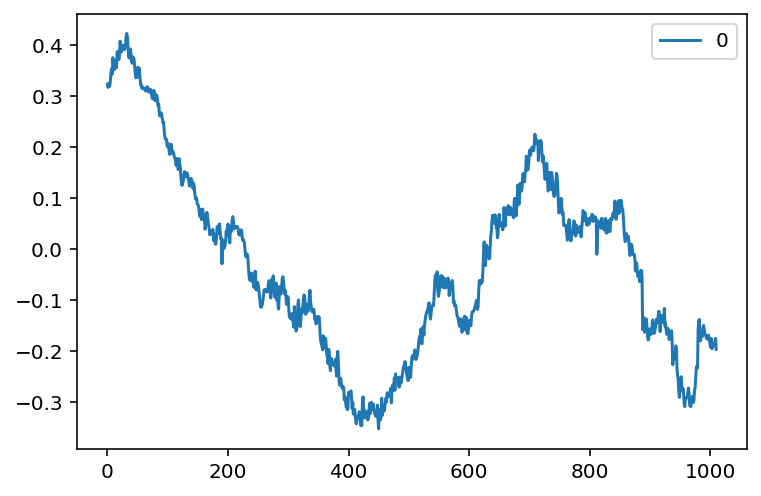

In [69]:
pd.DataFrame(y_pred).plot()

In [64]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     